데이터 셋 크기: (1567, 592)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass_Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB
None
                 0            1            2            3            4  \
count  1561.000000  1560.000000  1553.000000  1553.000000  1553.000000   
mean   3014.452896  2495.850231  2200.547318  1396.376627     4.197013   
std      73.621787    80.407705    29.513152   441.691640    56.355540   
min    2743.240000  2158.750000  2060.660000     0.000000     0.681500   
25%    2966.260000  2452.247500  2181.044400  1081.875800     1.017700   
50%    3011.490000  2499.405000  2201.066700  1285.214400     1.316800   
75%    3056.650000  2538.822500  2218.055500  1591.223500     1.525700   
max    3356.350000  2846.440000  2315.266700  3715.041700  1114.536600   

            5            6            7            8            9  ...  \
count  1553.0  1553.000000  1558.000000  1565.000000  

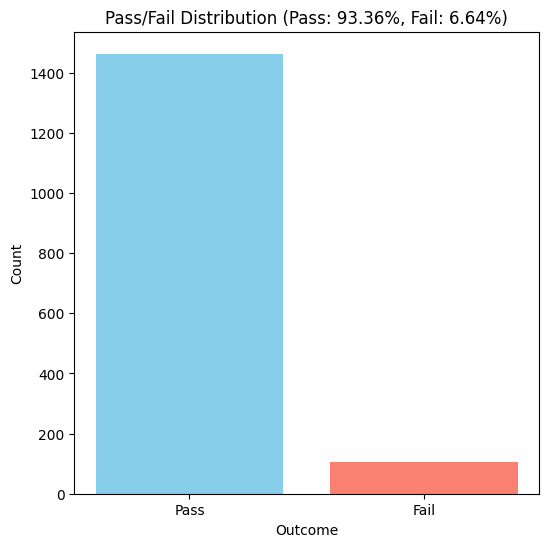

----- Step 1: 원본 데이터 (불균형) -----
                 Model  Accuracy       TPR       FPR
0        Decision Tree  0.853503  0.083333  0.082759
1          Naive Bayes  0.433121  0.750000  0.593103
2  Logistic Regression  0.888535  0.250000  0.058621
3                 K-NN  0.926752  0.041667  0.000000
4                  SVM  0.923567  0.000000  0.000000
5       Neural Network  0.904459  0.083333  0.027586

Step 1 평균 결과:
Accuracy    0.821656
TPR         0.201389
FPR         0.127011
dtype: float64


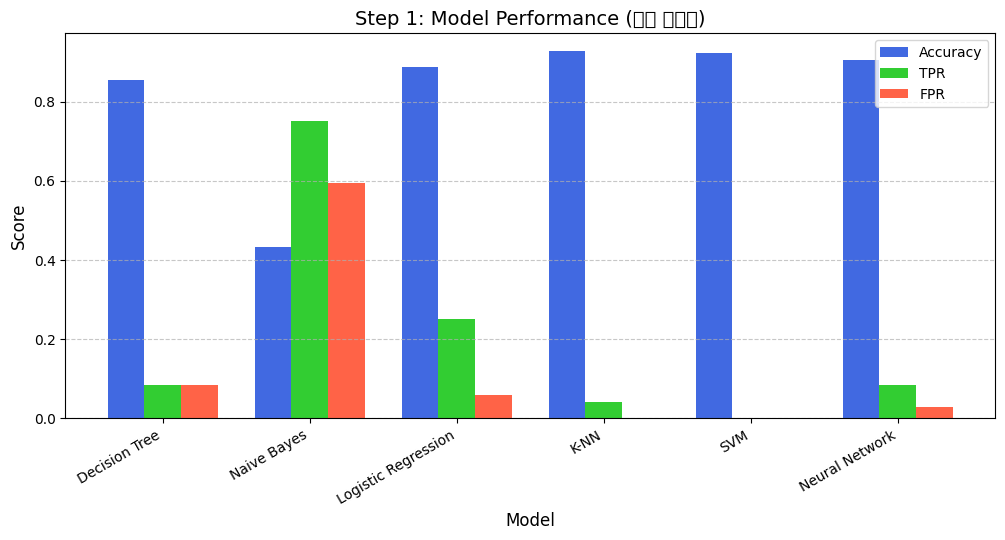

----- Step 2: SMOTE 적용 -----
훈련 데이터 보정 후 shape: (2346, 204)
                 Model  Accuracy       TPR       FPR
0        Decision Tree  0.847134  0.166667  0.096552
1          Naive Bayes  0.484076  0.625000  0.527586
2  Logistic Regression  0.796178  0.416667  0.172414
3                 K-NN  0.289809  0.916667  0.762069
4                  SVM  0.920382  0.041667  0.006897
5       Neural Network  0.898089  0.125000  0.037931

Step 2 평균 결과:
Accuracy    0.705945
TPR         0.381944
FPR         0.267241
dtype: float64


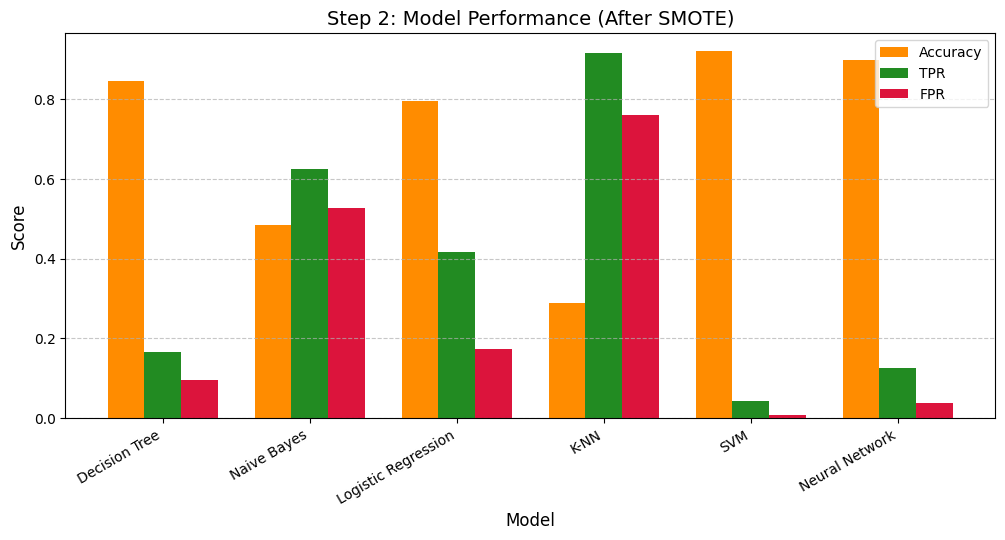

----- Step 3: SMOTE + PCA (차원 축소) -----
훈련 데이터 보정 후 shape (SMOTE 적용): (2346, 204)
PCA 후 X_train shape (Step 4): (2346, 50)
                 Model  Accuracy       TPR       FPR
0        Decision Tree  0.831210  0.333333  0.127586
1          Naive Bayes  0.802548  0.208333  0.148276
2  Logistic Regression  0.726115  0.333333  0.241379
3                 K-NN  0.859873  0.375000  0.100000
4                  SVM  0.907643  0.083333  0.024138
5       Neural Network  0.898089  0.166667  0.041379

Step 3 평균 결과:
Accuracy    0.837580
TPR         0.250000
FPR         0.113793
dtype: float64


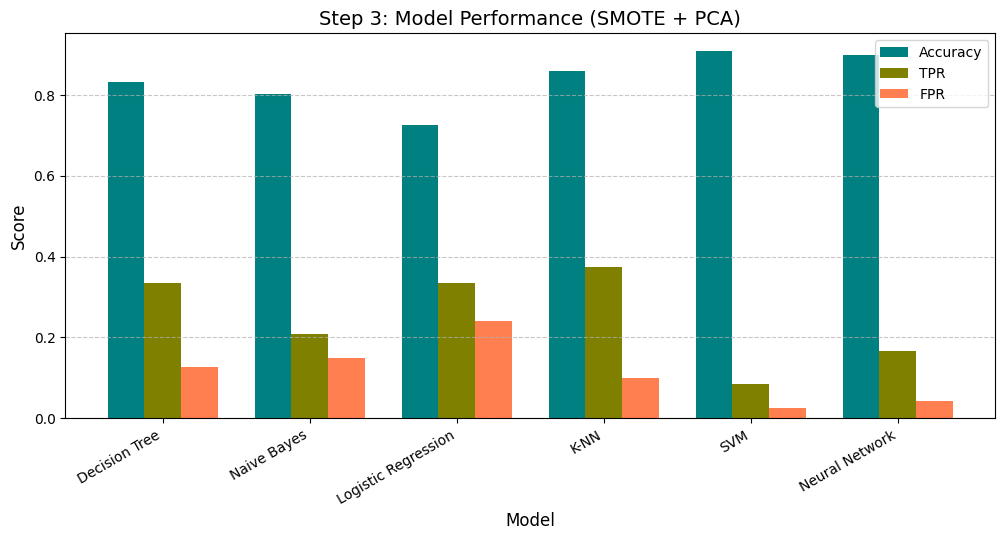

----- Step 4: SMOTE + 통계기반 피처선정 + PCA (최적화) -----
          Model  Accuracy   TPR       FPR
0  Hybrid Model   0.89172  0.25  0.055172

최적 분류기 (Best Estimator):
Pipeline(steps=[('feature_selection',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['28', '59', '63', '64', '79',
                                                   '103', '121', '122', '129',
                                                   '133', '144', '170', '183',
                                                   '468', '510'])])),
                ('hpca', HierarchicalPCA()),
                ('classifier', MLPClassifier(max_iter=1000))])

최적 분류기 파라미터 (Best Parameters):
{'classifier': MLPClassifier(max_iter=1000), 'hpca__n_clusters': 10}

Step 4 평균 결과:
Accuracy    0.891720
TPR         0.250000
FPR         0.055172
dtype: float64


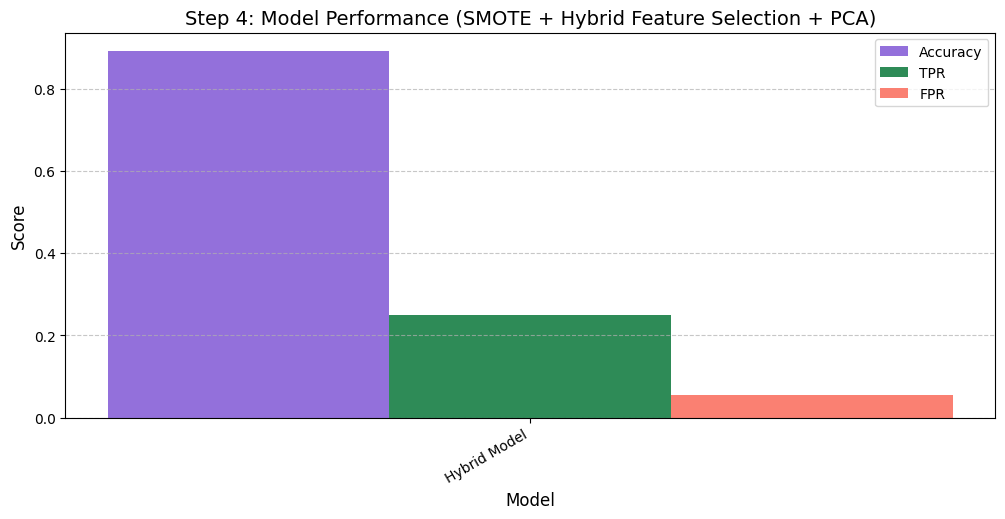

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import FeatureAgglomeration

import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. 데이터 로드 및 기본 정보
# =============================================================================
file_path = "secom.csv"  # 데이터 경로
data = pd.read_csv(file_path)
data.rename(columns={"Pass/Fail": "Pass_Fail"}, inplace=True)

def dataset_info(df):
    print("데이터 셋 크기:", df.shape)
    print(df.info())
    print(df.describe())

dataset_info(data)

# =============================================================================
# 2. 데이터 전처리
# =============================================================================
# 2.1 결측치 처리: 50% 이상 결측치가 있는 컬럼 제거 후, forward/backward fill
def missing_values(df):
    missing = df.isnull().sum()
    missing_percent = (missing / df.shape[0]) * 100
    missing_df = pd.DataFrame({'Missing_Records': missing, 'Percentage (%)': missing_percent})
    return missing_df[missing_df['Missing_Records'] > 0].sort_values(by='Percentage (%)', ascending=False)

missing_df = missing_values(data)
columns_to_drop = missing_df[missing_df["Percentage (%)"] > 50].index
data.drop(columns=columns_to_drop, inplace=True)
print(f"50% 이상 결측치가 포함된 {len(columns_to_drop)}개 컬럼 제거 후 데이터 크기: {data.shape}")

data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# 2.2 단일 값만 있는 컬럼 제거
unique_columns = [col for col in data.columns if data[col].nunique() == 1]
data.drop(columns=unique_columns, inplace=True)
print(f"단일 값만 포함된 {len(unique_columns)}개 컬럼 제거 후 데이터 크기: {data.shape}")

# 2.3 시간 데이터 제거
if "Time" in data.columns:
    data.drop(columns=["Time"], inplace=True)
    print("'Time' 컬럼 삭제 후 데이터 크기:", data.shape)

# 2.4 다중공선성이 높은 변수 제거 (상관계수 0.7 이상)
def remove_collinear_features(x, threshold=0.7):
    corr_matrix = x.corr()
    drop_cols = set()
    for i in range(len(corr_matrix.columns) - 1):
        for j in range(i + 1):
            if abs(corr_matrix.iloc[j, i+1]) >= threshold:
                drop_cols.add(corr_matrix.columns[i+1])
    return x.drop(columns=drop_cols)

data = remove_collinear_features(data, threshold=0.7)
print(f"다중공선성이 높은 변수 제거 후 데이터 크기: {data.shape}")

# 2.5 데이터 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=['Pass_Fail']))
data_scaled = pd.DataFrame(scaled_features, columns=data.drop(columns=['Pass_Fail']).columns)
data_scaled['Pass_Fail'] = data['Pass_Fail'].values
print("최종 데이터 크기:", data_scaled.shape)

# 2.6 불균형 분포 시각화
def plot_target_distribution(df):
    plt.figure(figsize=(6,6))
    labels = ['Pass', 'Fail']
    size = df['Pass_Fail'].value_counts()
    total = sum(size)
    percentages = [f'{(count / total) * 100:.2f}%' for count in size]
    colors = ['skyblue', 'salmon']
    plt.bar(labels, size, color=colors)
    plt.xlabel("Outcome")
    plt.ylabel("Count")
    plt.title(f"Pass/Fail Distribution (Pass: {percentages[0]}, Fail: {percentages[1]})")
    plt.show()

plot_target_distribution(data)

# =============================================================================
# 3. Train-Test Split (공통)
# =============================================================================
X = data_scaled.drop(columns=['Pass_Fail'])
y = data_scaled['Pass_Fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =============================================================================
# 4. 모델 정의 (공통)
# =============================================================================
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-NN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# =============================================================================
# Step 1: 원본 데이터 (불균형)로 모델 학습 및 평가
# =============================================================================
print("----- Step 1: 원본 데이터 (불균형) -----")
results_step1 = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    results_step1.append([name, acc, tpr, fpr])

results_df_step1 = pd.DataFrame(results_step1, columns=["Model", "Accuracy", "TPR", "FPR"])
print(results_df_step1)

# Step 1 평균 성능 계산 및 출력
mean_step1 = results_df_step1[['Accuracy','TPR','FPR']].mean()
print("\nStep 1 평균 결과:")
print(mean_step1)

bar_width = 0.25
index = np.arange(len(results_df_step1["Model"]))
plt.figure(figsize=(12, 5))
plt.bar(index, results_df_step1["Accuracy"], bar_width, label="Accuracy", color="royalblue")
plt.bar(index + bar_width, results_df_step1["TPR"], bar_width, label="TPR", color="limegreen")
plt.bar(index + 2*bar_width, results_df_step1["FPR"], bar_width, label="FPR", color="tomato")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Step 1: Model Performance (원본 데이터)", fontsize=14)
plt.xticks(index + bar_width, results_df_step1["Model"], rotation=30, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# =============================================================================
# Step 2: SMOTE (훈련 데이터에만 적용)
# =============================================================================
print("----- Step 2: SMOTE 적용 -----")
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("훈련 데이터 보정 후 shape:", X_train_smote.shape)

results_step2 = []
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    results_step2.append([name, acc, tpr, fpr])

results_df_step2 = pd.DataFrame(results_step2, columns=["Model", "Accuracy", "TPR", "FPR"])
print(results_df_step2)

# Step 2 평균 성능 계산 및 출력
mean_step2 = results_df_step2[['Accuracy','TPR','FPR']].mean()
print("\nStep 2 평균 결과:")
print(mean_step2)

plt.figure(figsize=(12, 5))
plt.bar(index, results_df_step2["Accuracy"], bar_width, label="Accuracy", color="darkorange")
plt.bar(index + bar_width, results_df_step2["TPR"], bar_width, label="TPR", color="forestgreen")
plt.bar(index + 2*bar_width, results_df_step2["FPR"], bar_width, label="FPR", color="crimson")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Step 2: Model Performance (After SMOTE)", fontsize=14)
plt.xticks(index + bar_width, results_df_step2["Model"], rotation=30, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# =============================================================================
# Step 3: SMOTE + PCA (차원 축소)
# =============================================================================
print("----- Step 3: SMOTE + PCA (차원 축소) -----")
X_train_smote_4, y_train_smote_4 = smote.fit_resample(X_train, y_train)
print("훈련 데이터 보정 후 shape (SMOTE 적용):", X_train_smote_4.shape)

pca_components = 50  # 필요에 따라 조정
pca4 = PCA(n_components=pca_components, random_state=42)
X_train_pca4 = pca4.fit_transform(X_train_smote_4)
X_test_pca4 = pca4.transform(X_test)
print("PCA 후 X_train shape (Step 4):", X_train_pca4.shape)

results_step4 = []
for name, model in models.items():
    model.fit(X_train_pca4, y_train_smote_4)
    y_pred = model.predict(X_test_pca4)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    results_step4.append([name, acc, tpr, fpr])

results_df_step4 = pd.DataFrame(results_step4, columns=["Model", "Accuracy", "TPR", "FPR"])
print(results_df_step4)

mean_step4 = results_df_step4[['Accuracy','TPR','FPR']].mean()
print("\nStep 3 평균 결과:")
print(mean_step4)

plt.figure(figsize=(12, 5))
plt.bar(index, results_df_step4["Accuracy"], bar_width, label="Accuracy", color="teal")
plt.bar(index + bar_width, results_df_step4["TPR"], bar_width, label="TPR", color="olive")
plt.bar(index + 2*bar_width, results_df_step4["FPR"], bar_width, label="FPR", color="coral")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Step 3: Model Performance (SMOTE + PCA)", fontsize=14)
plt.xticks(index + bar_width, results_df_step4["Model"], rotation=30, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# =============================================================================
# Step 4: SMOTE + 통계기반 피처선정 + PCA (최적화)
# =============================================================================
print("----- Step 4: SMOTE + 통계기반 피처선정 + PCA (최적화) -----")

# 1) SMOTE 적용 (훈련 데이터에 대해)
smote_fs = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote_fs, y_train_smote_fs = smote_fs.fit_resample(X_train, y_train)

# 2) 하이브리드 피처 선택 (상관계수 + 분산)
def hybrid_feature_selection(X, y, corr_th=0.2, var_th=0.1):
    # 각 피처와 타겟 간 Pearson 상관계수 계산
    corr_values = [pearsonr(X[col], y)[0] for col in X.columns]
    corr_df = pd.DataFrame({'feature': X.columns, 'corr': corr_values})
    corr_df['abs_corr'] = corr_df['corr'].abs()
    corr_df = corr_df[corr_df['abs_corr'] > corr_th]
    
    # VarianceThreshold 적용
    var_selector = VarianceThreshold(threshold=var_th)
    var_selector.fit(X[corr_df['feature']])
    selected_features = X[corr_df['feature']].columns[var_selector.get_support()]
    
    return selected_features

selected_features = hybrid_feature_selection(
    pd.DataFrame(X_train_smote_fs, columns=X_train.columns),
    y_train_smote_fs,
    corr_th=0.15,
    var_th=0.05
)

# 3) 계층적 PCA 적용 (HierarchicalPCA 클래스)
class HierarchicalPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, n_components=0.95):
        self.n_clusters = n_clusters
        self.n_components = n_components
        
    def fit(self, X, y=None):
        if not hasattr(X, 'columns'):
            self.feature_names_ = np.arange(X.shape[1])
            X_df = pd.DataFrame(X, columns=self.feature_names_)
        else:
            X_df = X.copy()
            self.feature_names_ = X_df.columns
        self.clusterer_ = FeatureAgglomeration(n_clusters=self.n_clusters)
        self.clusterer_.fit(X_df)
        self.cluster_labels_ = self.clusterer_.labels_
        self.pcas_ = {}
        for i in range(self.n_clusters):
            cluster_indices = np.where(self.cluster_labels_ == i)[0]
            subset = X_df.iloc[:, cluster_indices]
            pca = PCA(n_components=self.n_components)
            pca.fit(subset)
            self.pcas_[i] = (cluster_indices, pca)
        return self
    
    def transform(self, X):
        if not hasattr(X, 'columns'):
            X_df = pd.DataFrame(X, columns=self.feature_names_)
        else:
            X_df = X.copy()
        transformed_list = []
        for i in range(self.n_clusters):
            cluster_indices, pca = self.pcas_[i]
            subset = X_df.iloc[:, cluster_indices]
            transformed_cluster = pca.transform(subset)
            transformed_list.append(transformed_cluster)
        return np.hstack(transformed_list)

# 4) GridSearchCV를 통해 최적 파이프라인 구성 (최적화된 Hybrid Model)
pipeline = Pipeline([
    ('feature_selection', ColumnTransformer([
        ('selector', 'passthrough', list(selected_features))
    ])),
    ('hpca', HierarchicalPCA(n_clusters=15)),
    ('classifier', LogisticRegression(solver='saga', max_iter=1000))  # 초기값 (나중에 grid_search에서 대체됨)
])

# 분류기 후보군을 6개로 모두 추가
param_grid = {
    'hpca__n_clusters': [10, 15, 20],
    'classifier': [
        DecisionTreeClassifier(),
        GaussianNB(),
        LogisticRegression(max_iter=1000),
        KNeighborsClassifier(n_neighbors=5),
        SVC(kernel='rbf', C=1),
        MLPClassifier(max_iter=1000)
    ]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_smote_fs, y_train_smote_fs)

# 최적 파이프라인으로 예측 수행
y_pred_step3 = grid_search.predict(X_test)

acc_step3 = accuracy_score(y_test, y_pred_step3)
cm_step3 = confusion_matrix(y_test, y_pred_step3)
if cm_step3.size == 4:
    tn, fp, fn, tp = cm_step3.ravel()
else:
    tn, fp, fn, tp = 0, 0, 0, 0
tpr_step3 = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr_step3 = fp / (fp + tn) if (fp + tn) > 0 else 0

# Step 4 결과 출력 (단일 Hybrid Model)
results_step3 = pd.DataFrame([["Hybrid Model", acc_step3, tpr_step3, fpr_step3]],
                             columns=["Model", "Accuracy", "TPR", "FPR"])
print(results_step3)

# 선택된 최적 분류기 확인
best_estimator = grid_search.best_estimator_
print("\n최적 분류기 (Best Estimator):")
print(best_estimator)

print("\n최적 분류기 파라미터 (Best Parameters):")
print(grid_search.best_params_)

mean_step3 = results_step3[['Accuracy','TPR','FPR']].mean()
print("\nStep 4 평균 결과:")
print(mean_step3)

index3 = np.arange(len(results_step3["Model"]))
plt.figure(figsize=(12, 5))
plt.bar(index3, results_step3["Accuracy"], bar_width, label="Accuracy", color="mediumpurple")
plt.bar(index3 + bar_width, results_step3["TPR"], bar_width, label="TPR", color="seagreen")
plt.bar(index3 + 2*bar_width, results_step3["FPR"], bar_width, label="FPR", color="salmon")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Step 4: Model Performance (SMOTE + Hybrid Feature Selection + PCA)", fontsize=14)
plt.xticks(index3 + bar_width, results_step3["Model"], rotation=30, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
